# Dataset

"Challenges in Representation Learning: A report on three machine learning
contests." I Goodfellow, D Erhan, PL Carrier, A Courville, M Mirza, B
Hamner, W Cukierski, Y Tang, DH Lee, Y Zhou, C Ramaiah, F Feng, R Li,
X Wang, D Athanasakis, J Shawe-Taylor, M Milakov, J Park, R Ionescu,
M Popescu, C Grozea, J Bergstra, J Xie, L Romaszko, B Xu, Z Chuang, and
Y. Bengio. arXiv 2013.

In [122]:
import pandas as pd
import numpy as np
import cv2
import os
import glob

In [338]:
emotions_lookup = {0 : "angry", 1 : "disgust", 2 : "fear", 3 : "happy", 4 : "sad", 5 : "surprise", 6 : "neutral"}

In [124]:
def csv_to_files(csv, dataset_name):
    emotions_lookup = {0 : "angry", 1 : "disgust", 2 : "fear", 3 : "happy", 4 : "sad", 5 : "surprise", 6 : "neutral"}
    # create different folders for images, by emotions
    curdir = os.getcwd()
    dirs = set(emotions_lookup.values())
    for dr in dirs:
        dest = os.path.join(curdir, str(dr))
        if not os.path.exists(dest):
            os.mkdir(dest)
    for index, row in csv.iterrows():
        pixels = np.asarray(list(row["pixels"].split(" ")), dtype = np.uint8).reshape((48, 48))
        destdir = os.path.join(emotions_lookup[row["emotion"]])
        filepath = os.path.join(destdir,f"{destdir}_{dataset_name}{index}.jpg")
        if not os.path.exists(filepath):
            #print(f"{filepath} is created")
            cv2.imwrite(filepath, pixels)
        else:
            #print("Error")
            exit(-1)

In [125]:
fer_data = pd.read_csv("fer2013.csv")
csv_to_files(fer_data, "fer")

In [126]:
data_size = {}
path_df = pd.DataFrame(columns = ["folder_name","image_name","emotion","label"])
for i in range(7):
    emotion = emotions_lookup[i]
    # Select all file paths of images tagged with emotion i
    emotionFiles = glob.glob(f"./{emotion}/*.jpg")
    # Populate data_size file to understand sample size
    data_size[emotion] = len(emotionFiles)
    # Append data paths to df
    folder_name = [file[0:(file.rfind("/")+1)] for file in emotionFiles]
    image_name = [str(file.split("/")[-1]) for file in emotionFiles]
    emotion_array = [[emotion]*len(emotionFiles)][0]
    label = [i]*len(emotionFiles)
    d = {"folder_name":folder_name, "image_name":image_name, "emotion":emotion_array, "label":label}
    temp_emotion_df = pd.DataFrame(data = d)
    path_df= path_df.append(temp_emotion_df, ignore_index = True)
data_size

{'angry': 4953,
 'disgust': 547,
 'fear': 5121,
 'happy': 8989,
 'sad': 6077,
 'surprise': 4002,
 'neutral': 6198}

In [127]:
path_df

,folder_name,image_name,emotion,label
0,./angry/,angry_fer35270.jpg,angry,0
1,./angry/,angry_fer33601.jpg,angry,0
2,./angry/,angry_fer12817.jpg,angry,0
3,./angry/,angry_fer7793.jpg,angry,0
4,./angry/,angry_fer18484.jpg,angry,0
...,...,...,...,...
35882,./neutral/,neutral_fer936.jpg,neutral,6
35883,./neutral/,neutral_fer10969.jpg,neutral,6
35884,./neutral/,neutral_fer17960.jpg,neutral,6
35885,./neutral/,neutral_fer29656.jpg,neutral,6


# VGG-16 Feature Detection model

In [202]:
import sys, os
import cv2
from keras.applications import VGG16

In [204]:
# Convert emotion label to categorical matrix
emotions = pd.get_dummies(path_df["emotion"]).values

In [205]:
# Split data into training set and test set (85% training, 15% test)
x_train, x_test, y_train, y_test = train_test_split(path_df[["folder_name","image_name"]], emotions, train_size = 0.85, random_state = 42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((30503, 2), (5384, 2), (30503, 7), (5384, 7))

In [208]:
x_train = x_train.reset_index(drop= True)
x_test = x_test.reset_index(drop= True)

In [209]:
def load_images(image_df):
    images = []
    for i, row in image_df.iterrows():
        curdir = os.getcwd()
        path1 = row["folder_name"]                
        path2 = row["image_name"]              
        image = cv2.imread(os.path.join(curdir, path1, path2))
        images.append(image)
    return np.array(images)

x_train_images = load_images(x_train)
x_test_images = load_images(x_test)

In [210]:
x_train_images.shape, x_test_images.shape

((30503, 48, 48, 3), (5384, 48, 48, 3))

In [213]:
import pickle

pickle_out = open("x_train.pickle","wb")
pickle.dump(x_train_images, pickle_out)
pickle_out.close()

pickle_out = open("y_train.pickle","wb")
pickle.dump(y_train, pickle_out)
pickle_out.close()

pickle_out = open("x_test.pickle","wb")
pickle.dump(x_test_images, pickle_out)
pickle_out.close()

pickle_out = open("y_test.pickle","wb")
pickle.dump(y_test, pickle_out)
pickle_out.close()

# Test- What features do vgg-16 detect

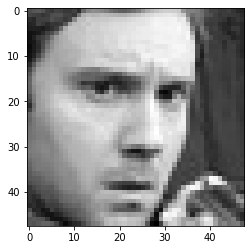

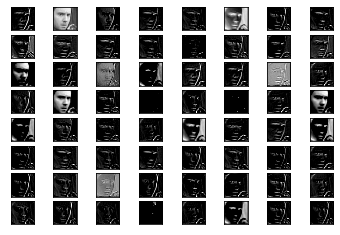

In [434]:
from keras.applications import vgg16
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras import Input
import matplotlib.pyplot as plt

# display source photo
photo = plt.imread('angry_fer0.jpg')
plt.imshow(photo, cmap='gray')
plt.show()

model = vgg16.VGG16(weights='imagenet', include_top=False)
model = Model(inputs=model.inputs, outputs=model.layers[1].output)

img_path = 'angry_fer0.jpg'
img = image.load_img(img_path)
x = np.array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x) # scale image pixels
feature_maps = model.predict(x)

# show features detected in first layer
square = 8
ix = 1
for i in range(square):
    for i in range(square):
        # specify subplot and turn of axis
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
        ix += 1
# show the figure
plt.show()

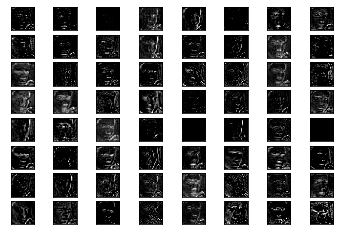

In [440]:
# features detected in a middle layer
model = vgg16.VGG16(weights='imagenet', include_top=False)
model = Model(inputs=model.inputs, outputs=model.layers[7].output)

img_path = 'angry_fer0.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = np.array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x) # scale image pixels
feature_maps = model.predict(x)

square = 8
ix = 1
for i in range(square):
    for i in range(square):
        # specify subplot and turn of axis
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
        ix += 1
# show the figure
plt.show()

<PIL.Image.Image image mode=RGB size=224x224 at 0x4619B2FD0>


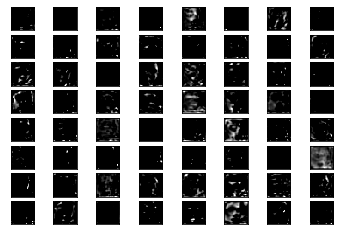

In [444]:
# features detected in final layer
model = vgg16.VGG16(weights='imagenet', include_top=False)
model = Model(inputs=model.inputs, outputs=model.layers[13].output)

img_path = 'angry_fer0.jpg'
img = image.load_img(img_path, target_size=(224, 224))
print(img)
x = np.array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x) # scale image pixels
feature_maps = model.predict(x)

square = 8
ix = 1
for i in range(square):
    for i in range(square):
        # specify subplot and turn of axis
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
        ix += 1
# show the figure
plt.show()

# Extract and save features

In [429]:
# VGG-16 has 13 convolution layers + 3 MLP layers
from keras.applications import vgg16
from keras.applications.vgg16 import preprocess_input
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten
from keras import Input
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard, ModelCheckpoint
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def extract_features≈(pickle_name):
    # retrieve pickles
    pickle_in = open(f"{pickle_name}.pickle","rb")
    file = pickle.load(pickle_in)

    vgg16_model = vgg16.VGG16(weights='imagenet', include_top=False)
    # pop the last 3 fully connected and softmax layers in vgg-16
    for i in range(33, 41):
        vgg16_model.layers.pop()
    
    features = []

    for i in range(len(file)):
        img = file[i]
        x = np.expand_dims(img, axis=0)
        x = preprocess_input(x) # scale image pixels
        feature = vgg16_model.predict(x)
        features.append(feature)
    
    return np.array(features)

In [468]:
def extract_features_image(image):
    vgg16_model = vgg16.VGG16(weights='imagenet', include_top=False)
    # pop the last 3 fully connected and softmax layers in vgg-16
    for i in range(33, 41):
        vgg16_model.layers.pop()
    x = np.expand_dims(image, axis=0)
    x = preprocess_input(x) # scale image pixels
    
    return vgg16_model.predict(x)

In [431]:
def pickle_out(pickle_name, data):
    pickle_out = open(f"{pickle_name}.pickle","wb")
    pickle.dump(data, pickle_out)
    pickle_out.close()

In [445]:
x_train_features = extract_features_dataset("x_train")
x_train_features.shape
pickle_out("x_train_features", x_train_features)

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_151 (InputLayer)       (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [446]:
x_test_features = extract_features_dataset("x_test")
x_test_features.shape
pickle_out("x_test_features", x_test_features)

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_152 (InputLayer)       (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [448]:
x_train.shape, x_train_features.shape, y_train.shape, x_train_features.shape[1:], x_train_features.shape[0]

((30503, 2), (30503, 1, 1, 1, 512), (30503, 7), (1, 1, 1, 512), 30503)

In [450]:
num_labels = 7

                          Loss    Accuracy    Val. Loss    Val. Accuracy

0.1 dropout

In [451]:
# Sequential Convolution Network for emotion clasification

model = Sequential()
model.add(Dense(512, activation='relu', input_shape = x_train_features.shape[1:]))
model.add(Dropout(0.1))
    
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())

model.add(Flatten())    
model.add(Dense(64, activation='relu'))
model.add(Dense(activation='softmax', units = num_labels)) 

model.summary()


Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_128 (Dense)            (None, 1, 1, 1, 512)      262656    
_________________________________________________________________
dropout_27 (Dropout)         (None, 1, 1, 1, 512)      0         
_________________________________________________________________
dense_129 (Dense)            (None, 1, 1, 1, 256)      131328    
_________________________________________________________________
dense_130 (Dense)            (None, 1, 1, 1, 128)      32896     
_________________________________________________________________
batch_normalization_25 (Batc (None, 1, 1, 1, 128)      512       
_________________________________________________________________
flatten_7 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_131 (Dense)            (None, 64)              

In [475]:
model_path = "./models/model.hdf5"
checkpoint_path = "./models/weights.{epoch:02d}-{val_loss:.2f}.hdf5"
model.compile(loss = 'categorical_crossentropy', optimizer = "Adam", metrics = ["accuracy"])

# reduce learning rate when the metric has stopped improving
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, cooldown = 5, verbose=1)

# stop training when the measured quantity has stopped improving
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0.005, patience=10, verbose=1, mode='auto')

# enable visualization for tensorboard
tensorboard = TensorBoard(log_dir='./logs', write_images = True)

# save model after every epoch (if specified) and restored to best model (if specified)
checkpointer = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True)

model.fit(x_train_features, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test_features, y_test),
          shuffle=True,
          callbacks=[lr_reducer, tensorboard, early_stopper, checkpointer]
         )

model.save(model_path) 

Train on 30503 samples, validate on 5384 samples
Epoch 1/20
30503/30503 [==============================] - 15s 496us/step - loss: 0.7482 - accuracy: 0.7342 - val_loss: 1.7879 - val_accuracy: 0.4552

Epoch 00001: val_loss improved from inf to 1.78792, saving model to ./models/weights.01-1.79.hdf5
Epoch 2/20
30503/30503 [==============================] - 15s 494us/step - loss: 0.7234 - accuracy: 0.7428 - val_loss: 1.8249 - val_accuracy: 0.4599

Epoch 00002: val_loss did not improve from 1.78792
Epoch 3/20
30503/30503 [==============================] - 15s 507us/step - loss: 0.6890 - accuracy: 0.7585 - val_loss: 1.9316 - val_accuracy: 0.4551

Epoch 00003: val_loss did not improve from 1.78792
Epoch 4/20
30503/30503 [==============================] - 15s 487us/step - loss: 0.6671 - accuracy: 0.7650 - val_loss: 1.8736 - val_accuracy: 0.4528

Epoch 00004: val_loss did not improve from 1.78792
Epoch 5/20
30503/30503 [==============================] - 15s 484us/step - loss: 0.6508 - accuracy: 

In [613]:
# reference: Scikit learn example code
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    
    classes = emotions_lookup.values()
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    
    fig, ax = plt.subplots(figsize=(10, 5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap,aspect='auto')
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(0.5, len(classes)),
           yticks=np.arange(0.5, len(classes)),
           # ... and label them with the respective list entries
           xticklabels=classes,
           yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    
    # fix dimensions, potential matplotlib bug
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom, top-1)
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), ha="right",rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


# Accuracy report and Confusion Matrix for training data

In [611]:
from sklearn.metrics import classification_report, confusion_matrix

# training set fit
predictions = model.predict(x_train_features)
print(classification_report(y_train.argmax(axis=1),predictions.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.95      0.83      0.89      4215
           1       0.96      0.89      0.92       470
           2       0.93      0.89      0.91      4364
           3       0.83      0.98      0.90      7666
           4       0.89      0.86      0.88      5267
           5       0.93      0.86      0.90      5140
           6       0.98      0.95      0.97      3381

    accuracy                           0.90     30503
   macro avg       0.92      0.89      0.91     30503
weighted avg       0.91      0.90      0.90     30503



Confusion matrix, without normalization
[[3509    7   99  326  157  103   14]
 [   3  416    8   31    5    5    2]
 [  69    3 3888  197   89   87   31]
 [  15    4   26 7483   90   33   15]
 [  45    3   51  544 4546   73    5]
 [  60    2   89  346  200 4435    8]
 [  12    0   40   62   30   14 3223]]


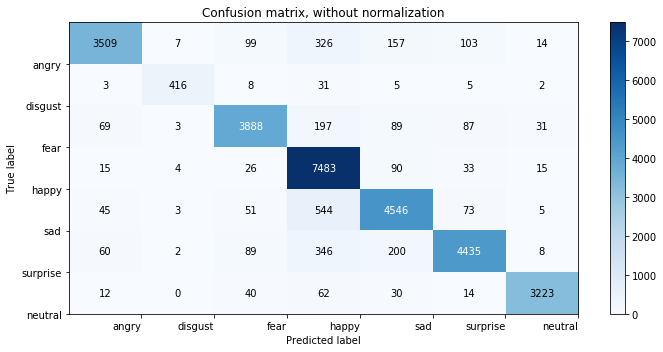

In [614]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_train.argmax(axis=1),predictions.argmax(axis=1),\
                      classes=emotions_lookup.values(),\
                      title='Confusion matrix, without normalization')

Normalized confusion matrix
[[8.33e-01 1.66e-03 2.35e-02 7.73e-02 3.72e-02 2.44e-02 3.32e-03]
 [6.38e-03 8.85e-01 1.70e-02 6.60e-02 1.06e-02 1.06e-02 4.26e-03]
 [1.58e-02 6.87e-04 8.91e-01 4.51e-02 2.04e-02 1.99e-02 7.10e-03]
 [1.96e-03 5.22e-04 3.39e-03 9.76e-01 1.17e-02 4.30e-03 1.96e-03]
 [8.54e-03 5.70e-04 9.68e-03 1.03e-01 8.63e-01 1.39e-02 9.49e-04]
 [1.17e-02 3.89e-04 1.73e-02 6.73e-02 3.89e-02 8.63e-01 1.56e-03]
 [3.55e-03 0.00e+00 1.18e-02 1.83e-02 8.87e-03 4.14e-03 9.53e-01]]


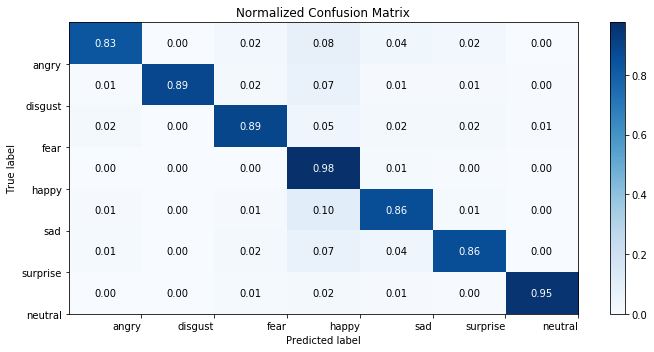

In [615]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_train.argmax(axis=1)\
                      ,predictions.argmax(axis=1), classes=emotions_lookup.values(),\
                      title="Normalized Confusion Matrix", normalize = True)

In [618]:
# validation result
predictions = model.predict(x_test_features)
print(classification_report(y_test.argmax(axis=1),predictions.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.41      0.28      0.33       738
           1       0.52      0.36      0.43        77
           2       0.43      0.41      0.42       757
           3       0.51      0.64      0.57      1323
           4       0.41      0.44      0.42       931
           5       0.39      0.33      0.35       937
           6       0.66      0.66      0.66       621

    accuracy                           0.47      5384
   macro avg       0.47      0.45      0.45      5384
weighted avg       0.46      0.47      0.46      5384



Confusion matrix, without normalization
[[207   7 105 142 114 120  43]
 [  5  28   6  14   8  12   4]
 [ 64   4 310 120 102  91  66]
 [ 69   3  58 852 172 123  46]
 [ 53   8  78 240 414 109  29]
 [ 89   2 113 228 173 306  26]
 [ 19   2  58  64  37  33 408]]


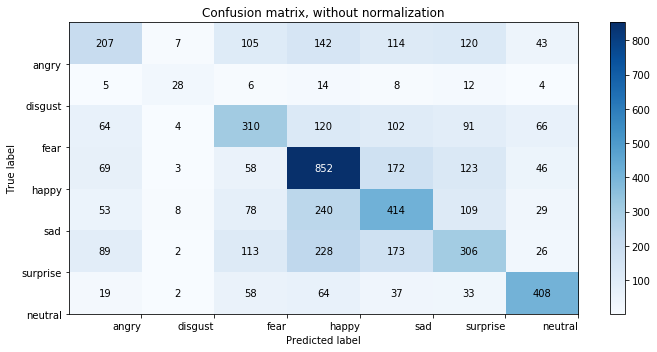

In [619]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test.argmax(axis=1),predictions.argmax(axis=1),\
                      classes=emotions_lookup.values(),\
                      title='Confusion matrix, without normalization')

Normalized confusion matrix
[[0.28 0.01 0.14 0.19 0.15 0.16 0.06]
 [0.06 0.36 0.08 0.18 0.1  0.16 0.05]
 [0.08 0.01 0.41 0.16 0.13 0.12 0.09]
 [0.05 0.   0.04 0.64 0.13 0.09 0.03]
 [0.06 0.01 0.08 0.26 0.44 0.12 0.03]
 [0.09 0.   0.12 0.24 0.18 0.33 0.03]
 [0.03 0.   0.09 0.1  0.06 0.05 0.66]]


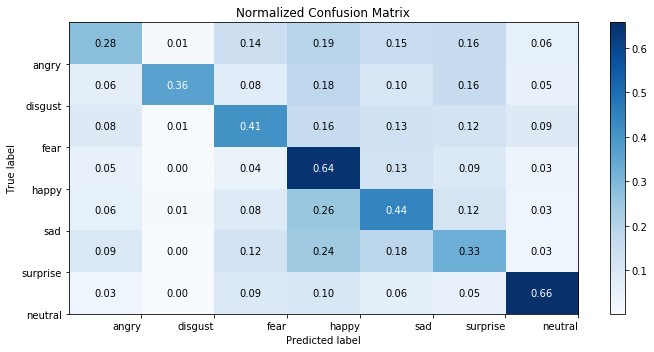

In [620]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test.argmax(axis=1)\
                      ,predictions.argmax(axis=1), classes=emotions_lookup.values(),\
                      title="Normalized Confusion Matrix", normalize = True)

In [478]:
def predict_emotions(image_path):
    im = cv2.imread(image_path)
    features = extract_features_image(im)
    features = np.expand_dims(features, axis=0)
    prediction = model.predict(features)
    return prediction.tolist()

angry 0.5294304490089417
disgust 0.0029831314459443092
fear 0.05637824535369873
happy 0.03754337504506111
sad 0.10427037626504898
surprise 0.26463979482650757
neutral 0.004754746798425913

Predicted emotion: angry, 52.94%


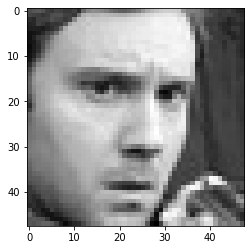

In [484]:
test_image1 = "./angry_fer0.jpg"
prediction = predict_emotions(test_image1)[0]
photo = plt.imread(test_image1)
plt.imshow(photo, cmap='gray')
for i in range(len(emotions_lookup)):
    print (emotions_lookup[i], prediction[i])
    
print(f"\nPredicted emotion: {emotions_lookup[prediction.index(max(prediction))]}, {round(max(prediction)*100,2)}%")



angry 0.010249319486320019
disgust 0.8576050400733948
fear 0.0545894019305706
happy 0.05914599820971489
sad 0.005029579158872366
surprise 0.003247749526053667
neutral 0.010132761672139168

Predicted emotion: disgust, 85.76%


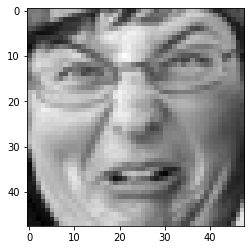

In [485]:
test_image2 = "./disgust_fer299.jpg"
prediction = predict_emotions(test_image2)[0]
photo = plt.imread(test_image2)
plt.imshow(photo, cmap='gray')
for i in range(len(emotions_lookup)):
    print (emotions_lookup[i], prediction[i])
   
print(f"\nPredicted emotion: {emotions_lookup[prediction.index(max(prediction))]}, {round(max(prediction)*100,2)}%")


angry 0.0013189602177590132
disgust 0.0038518328219652176
fear 0.0006391333299688995
happy 0.98641437292099
sad 0.005201618652790785
surprise 0.0024437177926301956
neutral 0.00013045402010902762

Predicted emotion: happy, 98.64%


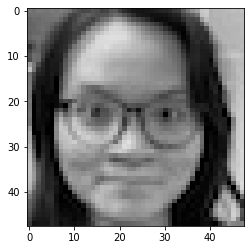

In [486]:
test_image3 = "./cutie.jpg"
prediction = predict_emotions(test_image3)[0]
photo = plt.imread(test_image3)
plt.imshow(photo, cmap='gray')
for i in range(len(emotions_lookup)):
    print (emotions_lookup[i], prediction[i])
   
print(f"\nPredicted emotion: {emotions_lookup[prediction.index(max(prediction))]}, {round(max(prediction)*100,2)}%")


In [490]:
scores = model.evaluate(x_train_features, y_train, batch_size=batch_size)
print("Loss: " + str(scores[0]))
print("Accuracy: " + str(scores[1]))

30503/30503 [==============================] - 2s 75us/step
Loss: 0.41154023305731363
Accuracy: 0.9015506505966187


In [487]:
scores = model.evaluate(x_test_features, y_test, batch_size=batch_size)
print("Loss: " + str(scores[0]))
print("Accuracy: " + str(scores[1]))

5384/5384 [==============================] - 0s 82us/step
Loss: 2.235265701787787
Accuracy: 0.46898216009140015


# Experiment with different Keras model setup

In [488]:
# obvious signs of over fitting
# test impact of increase drop out and increase # of neurons
model2 = Sequential() 
model2.add(Dense(1024, activation='relu', input_shape = x_train_features.shape[1:]))
model2.add(Dropout(0.3))
    
model2.add(Dense(512, activation='relu'))
model2.add(Dense(256, activation='relu'))
model2.add(BatchNormalization())
model2.add(Flatten()) 

model2.add(Dense(128, activation='relu'))
model2.add(Dense(activation='softmax', units = num_labels)) 

model2.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_133 (Dense)            (None, 1, 1, 1, 1024)     525312    
_________________________________________________________________
dropout_28 (Dropout)         (None, 1, 1, 1, 1024)     0         
_________________________________________________________________
dense_134 (Dense)            (None, 1, 1, 1, 512)      524800    
_________________________________________________________________
dense_135 (Dense)            (None, 1, 1, 1, 256)      131328    
_________________________________________________________________
batch_normalization_26 (Batc (None, 1, 1, 1, 256)      1024      
_________________________________________________________________
flatten_8 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_136 (Dense)            (None, 128)             

In [489]:
model2_path = "./models/model.hdf5"
model2.compile(loss = 'categorical_crossentropy', optimizer = "adam", metrics = ["accuracy"])

# reduce learning rate when the metric has stopped improving
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, cooldown = 5, verbose=1)

# stop training when the measured quantity has stopped improving
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0.005, patience=10, verbose=1, mode='auto')

# enable visualization for tensorboard
tensorboard = TensorBoard(log_dir='./logs', write_images = True)

# save model after every epoch (if specified) and restored to best model (if specified)
checkpointer = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True)

model2.fit(x_train_features, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test_features, y_test),
          shuffle=True,
          callbacks=[lr_reducer, tensorboard, early_stopper, checkpointer])

model2.save(model2_path) 

Train on 30503 samples, validate on 5384 samples
Epoch 1/20
30503/30503 [==============================] - 39s 1ms/step - loss: 1.6717 - accuracy: 0.3447 - val_loss: 1.6826 - val_accuracy: 0.3499

Epoch 00001: val_loss improved from inf to 1.68255, saving model to ./models/weights.01-1.68.hdf5
Epoch 2/20
30503/30503 [==============================] - 37s 1ms/step - loss: 1.5785 - accuracy: 0.3918 - val_loss: 1.5529 - val_accuracy: 0.3908

Epoch 00002: val_loss improved from 1.68255 to 1.55286, saving model to ./models/weights.02-1.55.hdf5
Epoch 3/20
30503/30503 [==============================] - 38s 1ms/step - loss: 1.5415 - accuracy: 0.4039 - val_loss: 1.6157 - val_accuracy: 0.3915

Epoch 00003: val_loss did not improve from 1.55286
Epoch 4/20
30503/30503 [==============================] - 35s 1ms/step - loss: 1.5058 - accuracy: 0.4239 - val_loss: 1.5584 - val_accuracy: 0.4014

Epoch 00004: val_loss did not improve from 1.55286
Epoch 5/20
30503/30503 [==============================] -